Using device: cuda


Epoch [30/30], loss_mean=0.707: 100%|██████████| 4/4 [00:02<00:00,  1.41it/s]


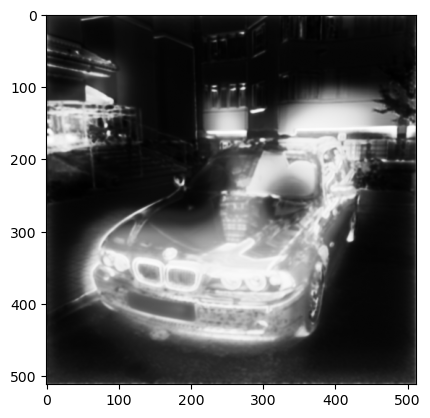

In [ ]:
# U-Net
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
import torch
import torch.utils.data as data
import torchvision
from torchvision import models
import torchvision.transforms.v2 as tfs_v2
import torch.nn as nn
import torch.optim as optim

# GPU setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


class SegmentDataset(data.Dataset):
    def __init__(self, path, transform_img=None, transform_mask = None, train=True):
        self.path = path
        self.transform_img = transform_img
        self.transform_mask = transform_mask

        path =  os.path.join(self.path, 'images')
        list_files = os.listdir(path)
        self.length = len(list_files)
        self.images = list(map (lambda _x : os.path.join(path, _x), list_files ))

        path =  os.path.join(self.path, 'masks')
        list_files = os.listdir(path)
        self.masks = list(map (lambda _x : os.path.join(path, _x), list_files ))

    def __getitem__(self, index):
        path_img, path_mask = self.images[index], self.masks[index]
        img = Image.open(path_img).convert('RGB')
        mask = Image.open(path_mask).convert('L') # gray

        if self.transform_img:
            img = self.transform_img(img)
            
        if self.transform_mask:
            mask = self.transform_mask(mask)
            # Binarization
            mask[mask < 250] = 1
            mask[mask >= 250] = 0
        return img, mask
            
    def __len__(self):
        return self.length

class UnetModel(nn.Module):
    class _TwoConvLayers(nn.Module):
        def __init__(self, in_channels, out_channels):
            super().__init__()
            self.model = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, padding=1, bias=False),
                nn.ReLU(inplace=True),
                nn.BatchNorm2d(out_channels),
                nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False),
                nn.ReLU(inplace=True),
                nn.BatchNorm2d(out_channels),
            )

        def forward(self, x):
            return self.model(x)
        
    class _EncoderBlock(nn.Module):
        def __init__(self, in_channels, out_channels):
            super().__init__()
            self.block = UnetModel._TwoConvLayers(in_channels, out_channels)
            self.max_pool = nn.MaxPool2d(2)

        def forward(self, x):
            x = self.block(x)
            y = self.max_pool(x)
            return y, x
        
    class _DecoderBlock(nn.Module):
        def __init__(self, in_channels, out_channels):
            super().__init__()
            self.transpose = nn.ConvTranspose2d(in_channels, out_channels, 2, stride=2)
            self.block = UnetModel._TwoConvLayers(in_channels, out_channels)

        def forward(self, x, y):
            x = self.transpose(x)
            u = torch.cat([x, y], dim=1)
            u = self.block(u)
            return u
        
    def __init__(self, in_channels=3, num_classes=1):
        super().__init__()
        self.enc_block1 = self._EncoderBlock(in_channels, 64)
        self.enc_block2 = self._EncoderBlock(64, 128)
        self.enc_block3 = self._EncoderBlock(128, 256)
        self.enc_block4 = self._EncoderBlock(256, 512)

        self.bottleneck = self._TwoConvLayers(512, 1024)

        self.dec_block1 = self._DecoderBlock(1024, 512)
        self.dec_block2 = self._DecoderBlock(512, 256)
        self.dec_block3 = self._DecoderBlock(256, 128)
        self.dec_block4 = self._DecoderBlock(128, 64)

        self.out = nn.Conv2d(64, num_classes, 1)

    def forward(self, x):
        x, y1 = self.enc_block1(x)
        x, y2 = self.enc_block2(x)
        x, y3 = self.enc_block3(x)
        x, y4 = self.enc_block4(x)

        x = self.bottleneck(x)

        x = self.dec_block1(x, y4)
        x = self.dec_block2(x, y3)
        x = self.dec_block3(x, y2)
        x = self.dec_block4(x, y1)

        return self.out(x)
    
class SoftDiceLoss(nn.Module):
    def __init__(self, smooth=1):
        super().__init__()
        self.smooth = smooth

    def forward(self, logits, targets):
        num = targets.size(0)
        probs = nn.functional.sigmoid(logits)
        m1 = probs.view(num, -1)
        m2 = targets.view(num, -1)
        intersection = (m1 * m2)

        score = 2 * (intersection.sum(1) + self.smooth) / (m1.sum(1) + m2.sum(1) + self.smooth)
        score = 1 - score.sum() / num
        return score
    


tr_img = tfs_v2.Compose([tfs_v2.ToImage(), tfs_v2.ToDtype(torch.float32, scale=True)])
tr_mask = tfs_v2.Compose([tfs_v2.ToImage(), tfs_v2.ToDtype(torch.float32)])

d_train = SegmentDataset(r"datasets\\dataset_seg", transform_img=tr_img, transform_mask=tr_mask)
train_data = data.DataLoader(d_train, batch_size=2, shuffle=True)

model = UnetModel()
# p = model(a.unsqueeze(0))
# print(model)

optimizer = optim.RMSprop(params=model.parameters(), lr=0.001)
loss_1 = nn.BCEWithLogitsLoss()
loss_2 = SoftDiceLoss()

epochs = 10
model.train()
model.to(device)

for _e in range(epochs):
    loss_mean = 0
    lm_count = 0

    train_tqdm = tqdm(train_data, leave=True)
    for x_train, y_train in train_tqdm:
        x_train = x_train.to(device)
        y_train = y_train.to(device)
        
        predict = model(x_train)
        loss = loss_1(predict, y_train) + loss_2(predict, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        lm_count += 1
        loss_mean = 1/lm_count * loss.item() + (1 - 1/lm_count) * loss_mean
        train_tqdm.set_description(f"Epoch [{_e+1}/{epochs}], loss_mean={loss_mean:.3f}")

st = model.state_dict()
torch.save(st, 'model_unet_seg.tar')

# st = torch.load('model_unet_seg.tar', weights_only=False)
# model.load_state_dict(st)

img = Image.open(r"datasets\\dataset_seg\\images\\IMG_9214.jpg").convert('RGB')
img = tr_img(img).unsqueeze(0).to(device)
model.eval()

p = model(img).squeeze(0)
x = nn.functional.sigmoid(p.permute(1, 2, 0))
x = x.cpu().detach().numpy() * 255
x = np.clip(x, 0, 255).astype('uint8')
plt.imshow(x, cmap='gray')
plt.show()


C:\Users\pantu\AppData\Local\Temp\ipykernel_9372\3351155671.py:315: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Using device: cuda
Loading datasets...
Train samples: 20, Val samples: 20

Initializing model...
Model parameters: 31,734,913

Starting training...


Epoch 1/50 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]C:\Users\pantu\AppData\Local\Temp\ipykernel_9372\3351155671.py:336: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/50 [Train]: 100%|██████████| 5/5 [00:03<00:00,  1.57it/s, loss=0.5294]
C:\Users\pantu\AppData\Local\Temp\ipykernel_9372\3351155671.py:360: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():



Epoch 1/50:
  Train Loss: 0.5981
  Val Loss: 0.6595 | Val Dice: 0.5116 | Val IoU: 0.3442
  ✅ Model saved! (Best Val Loss: 0.6595)
------------------------------------------------------------


Epoch 2/50 [Train]: 100%|██████████| 5/5 [00:02<00:00,  2.10it/s, loss=0.4662]



Epoch 2/50:
  Train Loss: 0.5205
  Val Loss: 0.6599 | Val Dice: 0.5111 | Val IoU: 0.3438
  Patience: 1/15
------------------------------------------------------------


Epoch 3/50 [Train]: 100%|██████████| 5/5 [00:02<00:00,  2.10it/s, loss=0.4467]



Epoch 3/50:
  Train Loss: 0.4726
  Val Loss: 0.6570 | Val Dice: 0.5134 | Val IoU: 0.3464
  ✅ Model saved! (Best Val Loss: 0.6570)
------------------------------------------------------------


Epoch 4/50 [Train]: 100%|██████████| 5/5 [00:02<00:00,  2.07it/s, loss=0.4280]



Epoch 4/50:
  Train Loss: 0.4508
  Val Loss: 0.6460 | Val Dice: 0.3019 | Val IoU: 0.1810
  ✅ Model saved! (Best Val Loss: 0.6460)
------------------------------------------------------------


Epoch 5/50 [Train]: 100%|██████████| 5/5 [00:02<00:00,  2.08it/s, loss=0.3592]



Epoch 5/50:
  Train Loss: 0.3849
  Val Loss: 0.6262 | Val Dice: 0.2583 | Val IoU: 0.1529
  ✅ Model saved! (Best Val Loss: 0.6262)
------------------------------------------------------------


Epoch 6/50 [Train]: 100%|██████████| 5/5 [00:02<00:00,  2.04it/s, loss=0.3959]



Epoch 6/50:
  Train Loss: 0.3918
  Val Loss: 0.5861 | Val Dice: 0.4832 | Val IoU: 0.3246
  ✅ Model saved! (Best Val Loss: 0.5861)
------------------------------------------------------------


Epoch 7/50 [Train]: 100%|██████████| 5/5 [00:02<00:00,  2.03it/s, loss=0.3569]



Epoch 7/50:
  Train Loss: 0.3894
  Val Loss: 0.5817 | Val Dice: 0.3694 | Val IoU: 0.2351
  ✅ Model saved! (Best Val Loss: 0.5817)
------------------------------------------------------------


Epoch 8/50 [Train]: 100%|██████████| 5/5 [00:02<00:00,  2.10it/s, loss=0.4227]



Epoch 8/50:
  Train Loss: 0.4129
  Val Loss: 0.6533 | Val Dice: 0.2635 | Val IoU: 0.1602
  Patience: 1/15
------------------------------------------------------------


Epoch 9/50 [Train]: 100%|██████████| 5/5 [00:02<00:00,  2.06it/s, loss=0.3330]



Epoch 9/50:
  Train Loss: 0.3773
  Val Loss: 0.5704 | Val Dice: 0.3967 | Val IoU: 0.2613
  ✅ Model saved! (Best Val Loss: 0.5704)
------------------------------------------------------------


Epoch 10/50 [Train]: 100%|██████████| 5/5 [00:02<00:00,  2.09it/s, loss=0.3724]



Epoch 10/50:
  Train Loss: 0.3927
  Val Loss: 0.4071 | Val Dice: 0.6624 | Val IoU: 0.5034
  ✅ Model saved! (Best Val Loss: 0.4071)
------------------------------------------------------------


Epoch 11/50 [Train]: 100%|██████████| 5/5 [00:02<00:00,  2.08it/s, loss=0.4164]



Epoch 11/50:
  Train Loss: 0.3691
  Val Loss: 0.3744 | Val Dice: 0.7437 | Val IoU: 0.5979
  ✅ Model saved! (Best Val Loss: 0.3744)
------------------------------------------------------------


Epoch 12/50 [Train]: 100%|██████████| 5/5 [00:02<00:00,  2.02it/s, loss=0.3458]



Epoch 12/50:
  Train Loss: 0.3695
  Val Loss: 0.3250 | Val Dice: 0.8294 | Val IoU: 0.7124
  ✅ Model saved! (Best Val Loss: 0.3250)
------------------------------------------------------------


Epoch 13/50 [Train]: 100%|██████████| 5/5 [00:02<00:00,  1.99it/s, loss=0.3261]



Epoch 13/50:
  Train Loss: 0.3560
  Val Loss: 0.3680 | Val Dice: 0.8150 | Val IoU: 0.6938
  Patience: 1/15
------------------------------------------------------------


Epoch 14/50 [Train]: 100%|██████████| 5/5 [00:02<00:00,  2.03it/s, loss=0.3444]



Epoch 14/50:
  Train Loss: 0.3722
  Val Loss: 0.3095 | Val Dice: 0.8348 | Val IoU: 0.7203
  ✅ Model saved! (Best Val Loss: 0.3095)
------------------------------------------------------------


Epoch 15/50 [Train]: 100%|██████████| 5/5 [00:02<00:00,  2.07it/s, loss=0.4504]



Epoch 15/50:
  Train Loss: 0.3716
  Val Loss: 0.3406 | Val Dice: 0.7941 | Val IoU: 0.6633
  Patience: 1/15
------------------------------------------------------------


Epoch 16/50 [Train]: 100%|██████████| 5/5 [00:02<00:00,  2.04it/s, loss=0.3091]



Epoch 16/50:
  Train Loss: 0.3480
  Val Loss: 0.2979 | Val Dice: 0.8235 | Val IoU: 0.7042
  ✅ Model saved! (Best Val Loss: 0.2979)
------------------------------------------------------------


Epoch 17/50 [Train]: 100%|██████████| 5/5 [00:02<00:00,  2.07it/s, loss=0.3827]



Epoch 17/50:
  Train Loss: 0.3409
  Val Loss: 0.3005 | Val Dice: 0.8397 | Val IoU: 0.7264
  Patience: 1/15
------------------------------------------------------------


Epoch 18/50 [Train]: 100%|██████████| 5/5 [00:02<00:00,  2.07it/s, loss=0.2996]



Epoch 18/50:
  Train Loss: 0.3599
  Val Loss: 0.3004 | Val Dice: 0.8331 | Val IoU: 0.7186
  Patience: 2/15
------------------------------------------------------------


Epoch 19/50 [Train]: 100%|██████████| 5/5 [00:02<00:00,  2.03it/s, loss=0.3062]



Epoch 19/50:
  Train Loss: 0.3227
  Val Loss: 0.2999 | Val Dice: 0.8390 | Val IoU: 0.7277
  Patience: 3/15
------------------------------------------------------------


Epoch 20/50 [Train]: 100%|██████████| 5/5 [00:02<00:00,  2.09it/s, loss=0.3357]



Epoch 20/50:
  Train Loss: 0.2874
  Val Loss: 0.3077 | Val Dice: 0.8404 | Val IoU: 0.7292
  Patience: 4/15
------------------------------------------------------------


Epoch 21/50 [Train]: 100%|██████████| 5/5 [00:02<00:00,  2.00it/s, loss=0.3450]



Epoch 21/50:
  Train Loss: 0.3255
  Val Loss: 0.2878 | Val Dice: 0.8484 | Val IoU: 0.7405
  ✅ Model saved! (Best Val Loss: 0.2878)
------------------------------------------------------------


Epoch 22/50 [Train]: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s, loss=0.2820]



Epoch 22/50:
  Train Loss: 0.3219
  Val Loss: 0.3034 | Val Dice: 0.8333 | Val IoU: 0.7169
  Patience: 1/15
------------------------------------------------------------


Epoch 23/50 [Train]: 100%|██████████| 5/5 [00:02<00:00,  2.03it/s, loss=0.3286]



Epoch 23/50:
  Train Loss: 0.3341
  Val Loss: 0.2906 | Val Dice: 0.8328 | Val IoU: 0.7161
  Patience: 2/15
------------------------------------------------------------


Epoch 24/50 [Train]: 100%|██████████| 5/5 [00:02<00:00,  2.09it/s, loss=0.2943]



Epoch 24/50:
  Train Loss: 0.2925
  Val Loss: 0.2745 | Val Dice: 0.8508 | Val IoU: 0.7422
  ✅ Model saved! (Best Val Loss: 0.2745)
------------------------------------------------------------


Epoch 25/50 [Train]: 100%|██████████| 5/5 [00:02<00:00,  1.98it/s, loss=0.3208]



Epoch 25/50:
  Train Loss: 0.3293
  Val Loss: 0.2592 | Val Dice: 0.8630 | Val IoU: 0.7611
  ✅ Model saved! (Best Val Loss: 0.2592)
------------------------------------------------------------


Epoch 26/50 [Train]: 100%|██████████| 5/5 [00:02<00:00,  2.02it/s, loss=0.2503]



Epoch 26/50:
  Train Loss: 0.2716
  Val Loss: 0.2706 | Val Dice: 0.8588 | Val IoU: 0.7551
  Patience: 1/15
------------------------------------------------------------


Epoch 27/50 [Train]: 100%|██████████| 5/5 [00:02<00:00,  1.98it/s, loss=0.3525]



Epoch 27/50:
  Train Loss: 0.2823
  Val Loss: 0.2946 | Val Dice: 0.8551 | Val IoU: 0.7496
  Patience: 2/15
------------------------------------------------------------


Epoch 28/50 [Train]: 100%|██████████| 5/5 [00:02<00:00,  2.07it/s, loss=0.2980]



Epoch 28/50:
  Train Loss: 0.2635
  Val Loss: 0.3377 | Val Dice: 0.8026 | Val IoU: 0.6722
  Patience: 3/15
------------------------------------------------------------


Epoch 29/50 [Train]: 100%|██████████| 5/5 [00:02<00:00,  2.07it/s, loss=0.3183]



Epoch 29/50:
  Train Loss: 0.2970
  Val Loss: 0.3272 | Val Dice: 0.8079 | Val IoU: 0.6805
  Patience: 4/15
------------------------------------------------------------


Epoch 30/50 [Train]: 100%|██████████| 5/5 [00:02<00:00,  2.09it/s, loss=0.3780]



Epoch 30/50:
  Train Loss: 0.3317
  Val Loss: 0.2737 | Val Dice: 0.8426 | Val IoU: 0.7317
  Patience: 5/15
------------------------------------------------------------


Epoch 31/50 [Train]: 100%|██████████| 5/5 [00:02<00:00,  2.08it/s, loss=0.3407]



Epoch 31/50:
  Train Loss: 0.3098
  Val Loss: 0.2495 | Val Dice: 0.8572 | Val IoU: 0.7525
  ✅ Model saved! (Best Val Loss: 0.2495)
------------------------------------------------------------


Epoch 32/50 [Train]: 100%|██████████| 5/5 [00:02<00:00,  2.08it/s, loss=0.2853]



Epoch 32/50:
  Train Loss: 0.2711
  Val Loss: 0.2471 | Val Dice: 0.8667 | Val IoU: 0.7662
  ✅ Model saved! (Best Val Loss: 0.2471)
------------------------------------------------------------


Epoch 33/50 [Train]: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s, loss=0.2629]



Epoch 33/50:
  Train Loss: 0.2707
  Val Loss: 0.2616 | Val Dice: 0.8533 | Val IoU: 0.7467
  Patience: 1/15
------------------------------------------------------------


Epoch 34/50 [Train]: 100%|██████████| 5/5 [00:02<00:00,  2.07it/s, loss=0.2312]



Epoch 34/50:
  Train Loss: 0.2452
  Val Loss: 0.3177 | Val Dice: 0.8113 | Val IoU: 0.6855
  Patience: 2/15
------------------------------------------------------------


Epoch 35/50 [Train]: 100%|██████████| 5/5 [00:02<00:00,  2.03it/s, loss=0.2953]



Epoch 35/50:
  Train Loss: 0.2593
  Val Loss: 0.3063 | Val Dice: 0.7943 | Val IoU: 0.6641
  Patience: 3/15
------------------------------------------------------------


Epoch 36/50 [Train]: 100%|██████████| 5/5 [00:02<00:00,  2.06it/s, loss=0.2860]



Epoch 36/50:
  Train Loss: 0.3029
  Val Loss: 0.2668 | Val Dice: 0.8630 | Val IoU: 0.7613
  Patience: 4/15
------------------------------------------------------------


Epoch 37/50 [Train]: 100%|██████████| 5/5 [00:02<00:00,  2.04it/s, loss=0.2770]



Epoch 37/50:
  Train Loss: 0.2573
  Val Loss: 0.2407 | Val Dice: 0.8850 | Val IoU: 0.7949
  ✅ Model saved! (Best Val Loss: 0.2407)
------------------------------------------------------------


Epoch 38/50 [Train]: 100%|██████████| 5/5 [00:02<00:00,  2.07it/s, loss=0.3618]



Epoch 38/50:
  Train Loss: 0.2778
  Val Loss: 0.2312 | Val Dice: 0.8839 | Val IoU: 0.7947
  ✅ Model saved! (Best Val Loss: 0.2312)
------------------------------------------------------------


Epoch 39/50 [Train]: 100%|██████████| 5/5 [00:02<00:00,  2.03it/s, loss=0.2877]



Epoch 39/50:
  Train Loss: 0.2505
  Val Loss: 0.2184 | Val Dice: 0.8966 | Val IoU: 0.8148
  ✅ Model saved! (Best Val Loss: 0.2184)
------------------------------------------------------------


Epoch 40/50 [Train]: 100%|██████████| 5/5 [00:02<00:00,  2.10it/s, loss=0.2466]



Epoch 40/50:
  Train Loss: 0.2575
  Val Loss: 0.2327 | Val Dice: 0.8850 | Val IoU: 0.7951
  Patience: 1/15
------------------------------------------------------------


Epoch 41/50 [Train]: 100%|██████████| 5/5 [00:02<00:00,  2.07it/s, loss=0.2178]



Epoch 41/50:
  Train Loss: 0.2806
  Val Loss: 0.3147 | Val Dice: 0.8061 | Val IoU: 0.6782
  Patience: 2/15
------------------------------------------------------------


Epoch 42/50 [Train]: 100%|██████████| 5/5 [00:02<00:00,  1.99it/s, loss=0.3062]



Epoch 42/50:
  Train Loss: 0.2851
  Val Loss: 0.2498 | Val Dice: 0.8666 | Val IoU: 0.7670
  Patience: 3/15
------------------------------------------------------------


Epoch 43/50 [Train]: 100%|██████████| 5/5 [00:02<00:00,  1.99it/s, loss=0.2688]



Epoch 43/50:
  Train Loss: 0.2875
  Val Loss: 0.2418 | Val Dice: 0.8628 | Val IoU: 0.7597
  Patience: 4/15
------------------------------------------------------------


Epoch 44/50 [Train]: 100%|██████████| 5/5 [00:02<00:00,  1.97it/s, loss=0.3105]



Epoch 44/50:
  Train Loss: 0.2666
  Val Loss: 0.2154 | Val Dice: 0.8857 | Val IoU: 0.7957
  ✅ Model saved! (Best Val Loss: 0.2154)
------------------------------------------------------------


Epoch 45/50 [Train]: 100%|██████████| 5/5 [00:02<00:00,  2.00it/s, loss=0.2673]



Epoch 45/50:
  Train Loss: 0.2447
  Val Loss: 0.2113 | Val Dice: 0.8903 | Val IoU: 0.8035
  ✅ Model saved! (Best Val Loss: 0.2113)
------------------------------------------------------------


Epoch 46/50 [Train]: 100%|██████████| 5/5 [00:02<00:00,  1.98it/s, loss=0.2425]



Epoch 46/50:
  Train Loss: 0.2330
  Val Loss: 0.2159 | Val Dice: 0.8910 | Val IoU: 0.8044
  Patience: 1/15
------------------------------------------------------------


Epoch 47/50 [Train]: 100%|██████████| 5/5 [00:02<00:00,  2.12it/s, loss=0.2311]



Epoch 47/50:
  Train Loss: 0.2359
  Val Loss: 0.2399 | Val Dice: 0.8814 | Val IoU: 0.7889
  Patience: 2/15
------------------------------------------------------------


Epoch 48/50 [Train]: 100%|██████████| 5/5 [00:02<00:00,  2.06it/s, loss=0.1999]



Epoch 48/50:
  Train Loss: 0.2200
  Val Loss: 0.2294 | Val Dice: 0.8893 | Val IoU: 0.8018
  Patience: 3/15
------------------------------------------------------------


Epoch 49/50 [Train]: 100%|██████████| 5/5 [00:02<00:00,  2.12it/s, loss=0.2993]



Epoch 49/50:
  Train Loss: 0.2502
  Val Loss: 0.2570 | Val Dice: 0.8652 | Val IoU: 0.7655
  Patience: 4/15
------------------------------------------------------------


Epoch 50/50 [Train]: 100%|██████████| 5/5 [00:02<00:00,  2.10it/s, loss=0.2106]



Epoch 50/50:
  Train Loss: 0.2445
  Val Loss: 0.2445 | Val Dice: 0.8699 | Val IoU: 0.7730
  Patience: 5/15
------------------------------------------------------------


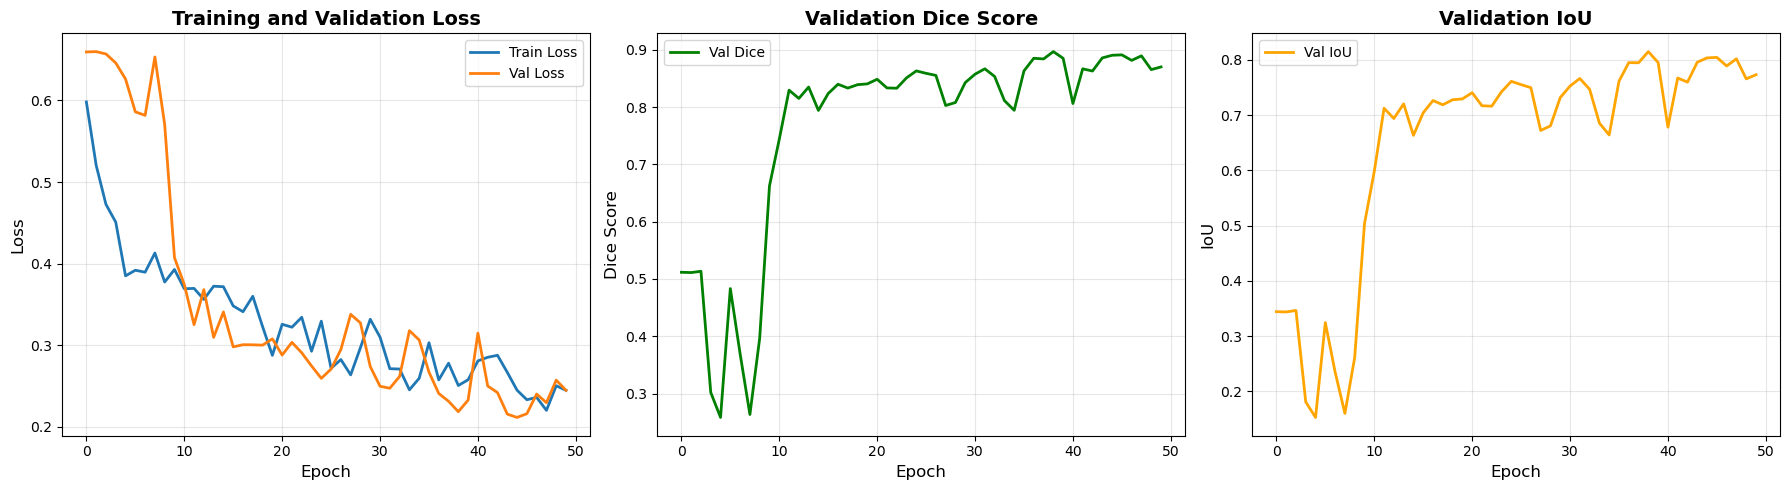

Training history saved to training_history.png

Loading best model...
Best model from epoch 45
  Val Loss: 0.2113
  Val Dice: 0.8903
  Val IoU: 0.8035

Calculating final metrics on validation set...
Final Validation Metrics:
  IoU: 0.8035
  Dice: 0.8902
  Precision: 0.8933
  Recall: 0.8918

Generating prediction visualizations...


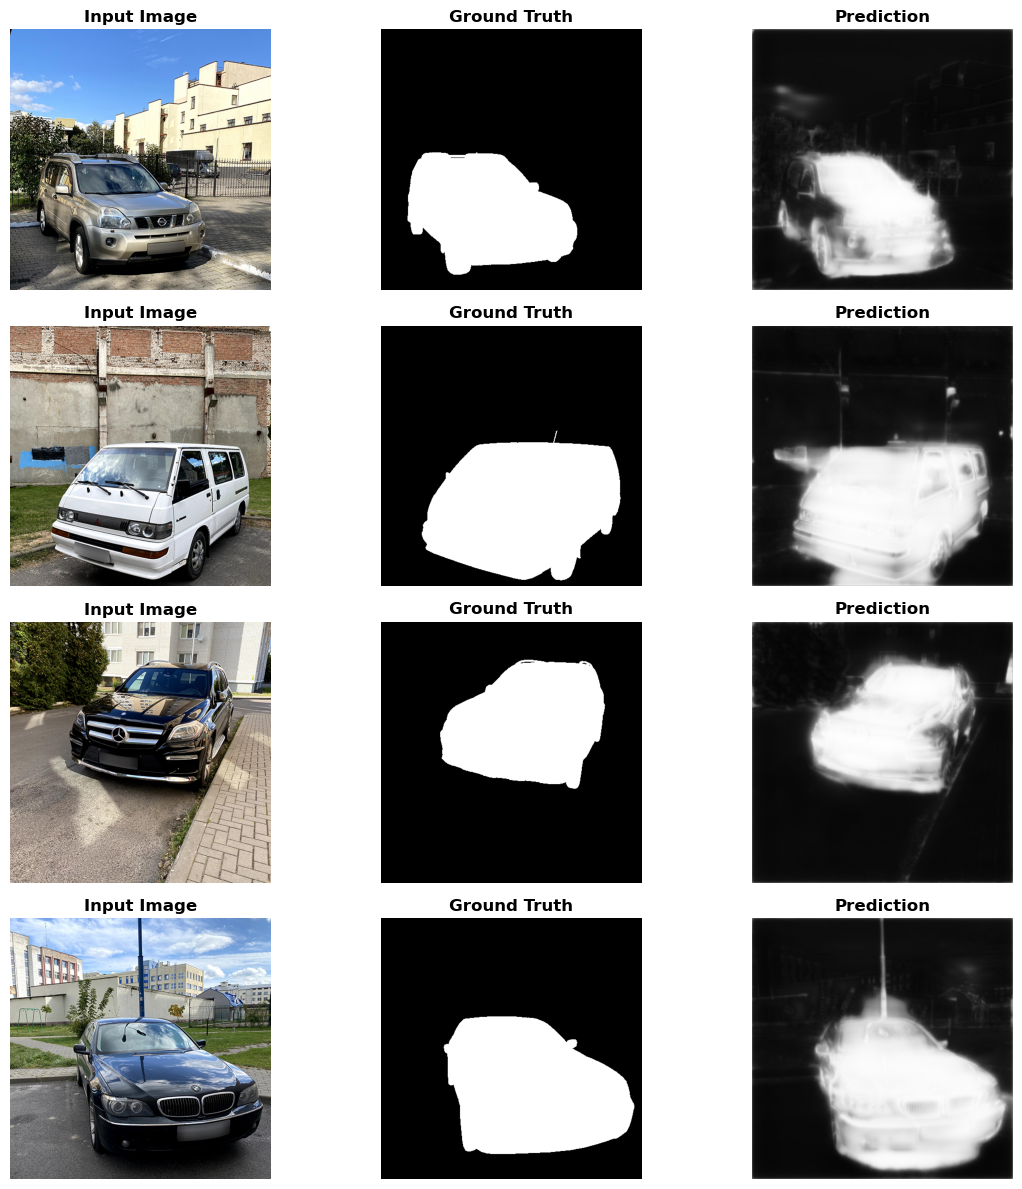

Predictions saved to predictions.png

Example inference on single image...


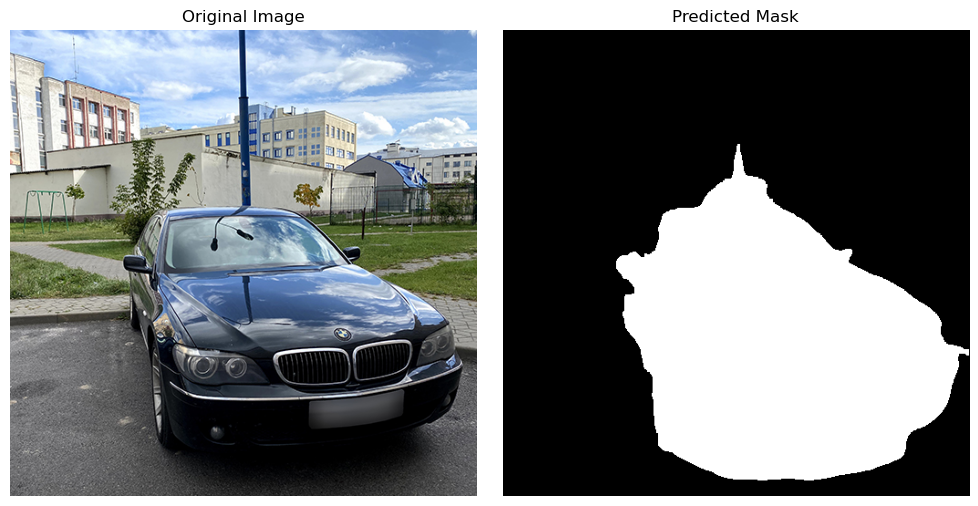


✅ Training complete!


In [5]:
# Improved U-Net for Image Segmentation
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage

from tqdm import tqdm
import torch
import torch.utils.data as data
import torchvision.transforms.v2 as tfs_v2
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import autocast, GradScaler

# GPU setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


# ========================================
# DATASET WITH AUGMENTATIONS
# ========================================
class SegmentDataset(data.Dataset):
    def __init__(self, path, transform_img=None, transform_mask=None, train=True):
        self.path = path
        self.transform_img = transform_img
        self.transform_mask = transform_mask
        self.train = train

        path_images = os.path.join(self.path, 'images')
        list_files = os.listdir(path_images)
        self.length = len(list_files)
        self.images = [os.path.join(path_images, f) for f in list_files]

        path_masks = os.path.join(self.path, 'masks')
        list_files = os.listdir(path_masks)
        self.masks = [os.path.join(path_masks, f) for f in list_files]

        # Аугментации для обучения
        if self.train:
            self.geometric_aug = tfs_v2.Compose([
                tfs_v2.RandomHorizontalFlip(p=0.5),
                tfs_v2.RandomVerticalFlip(p=0.5),
                tfs_v2.RandomRotation(degrees=20),
                tfs_v2.RandomAffine(
                    degrees=0,
                    translate=(0.1, 0.1),
                    scale=(0.9, 1.1),
                    shear=10
                ),
                tfs_v2.ElasticTransform(alpha=50.0, sigma=5.0),
            ])
            
            # Цветовые аугментации только для изображения
            self.color_aug = tfs_v2.Compose([
                tfs_v2.ColorJitter(
                    brightness=0.3,
                    contrast=0.3,
                    saturation=0.3,
                    hue=0.1
                ),
                tfs_v2.RandomAdjustSharpness(sharpness_factor=2, p=0.5),
                tfs_v2.RandomAutocontrast(p=0.5),
            ])

    def __getitem__(self, index):
        path_img, path_mask = self.images[index], self.masks[index]
        img = Image.open(path_img).convert('RGB')
        mask = Image.open(path_mask).convert('L')

        if self.train:
            # Применяем геометрические трансформации с одним seed
            seed = torch.randint(0, 2**32, (1,)).item()
            
            torch.manual_seed(seed)
            img = self.geometric_aug(img)
            
            torch.manual_seed(seed)
            mask = self.geometric_aug(mask)
            
            # Цветовые аугментации только для изображения
            img = self.color_aug(img)

        # Финальные трансформации
        if self.transform_img:
            img = self.transform_img(img)
            
        if self.transform_mask:
            mask = self.transform_mask(mask)
            # Бинаризация
            mask = (mask < 0.98).float()  # 250/255 ≈ 0.98
            
        return img, mask
            
    def __len__(self):
        return self.length


# ========================================
# IMPROVED U-NET MODEL
# ========================================
class ImprovedUnetModel(nn.Module):
    class _TwoConvLayers(nn.Module):
        def __init__(self, in_channels, out_channels, dropout=0.1):
            super().__init__()
            self.model = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, padding=1, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Dropout2d(dropout),
                nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
            )

        def forward(self, x):
            return self.model(x)
        
    class _EncoderBlock(nn.Module):
        def __init__(self, in_channels, out_channels, dropout=0.1):
            super().__init__()
            self.block = ImprovedUnetModel._TwoConvLayers(in_channels, out_channels, dropout)
            self.max_pool = nn.MaxPool2d(2)

        def forward(self, x):
            x = self.block(x)
            y = self.max_pool(x)
            return y, x
        
    class _DecoderBlock(nn.Module):
        def __init__(self, in_channels, out_channels, dropout=0.1, use_attention=True):
            super().__init__()
            self.transpose = nn.ConvTranspose2d(in_channels, out_channels, 2, stride=2)
            self.block = ImprovedUnetModel._TwoConvLayers(in_channels, out_channels, dropout)
            
            # Attention механизм
            self.use_attention = use_attention
            if use_attention:
                self.attention = nn.Sequential(
                    nn.Conv2d(in_channels, out_channels, 1),
                    nn.Sigmoid()
                )

        def forward(self, x, y):
            x = self.transpose(x)
            
            # Применяем attention к skip connection
            if self.use_attention:
                attention_weights = self.attention(torch.cat([x, y], dim=1))
                y = y * attention_weights
            
            u = torch.cat([x, y], dim=1)
            u = self.block(u)
            return u
    
    def __init__(self, in_channels=3, num_classes=1, dropout=0.1, use_attention=True):
        super().__init__()
        self.enc_block1 = self._EncoderBlock(in_channels, 64, dropout)
        self.enc_block2 = self._EncoderBlock(64, 128, dropout)
        self.enc_block3 = self._EncoderBlock(128, 256, dropout)
        self.enc_block4 = self._EncoderBlock(256, 512, dropout)

        self.bottleneck = self._TwoConvLayers(512, 1024, dropout)

        self.dec_block1 = self._DecoderBlock(1024, 512, dropout, use_attention)
        self.dec_block2 = self._DecoderBlock(512, 256, dropout, use_attention)
        self.dec_block3 = self._DecoderBlock(256, 128, dropout, use_attention)
        self.dec_block4 = self._DecoderBlock(128, 64, dropout, use_attention)

        self.out = nn.Conv2d(64, num_classes, 1)

    def forward(self, x):
        x, y1 = self.enc_block1(x)
        x, y2 = self.enc_block2(x)
        x, y3 = self.enc_block3(x)
        x, y4 = self.enc_block4(x)

        x = self.bottleneck(x)

        x = self.dec_block1(x, y4)
        x = self.dec_block2(x, y3)
        x = self.dec_block3(x, y2)
        x = self.dec_block4(x, y1)

        return self.out(x)


# ========================================
# LOSS FUNCTIONS
# ========================================
class SoftDiceLoss(nn.Module):
    def __init__(self, smooth=1):
        super().__init__()
        self.smooth = smooth

    def forward(self, logits, targets):
        num = targets.size(0)
        probs = torch.sigmoid(logits)
        m1 = probs.view(num, -1)
        m2 = targets.view(num, -1)
        intersection = (m1 * m2)

        score = 2 * (intersection.sum(1) + self.smooth) / (m1.sum(1) + m2.sum(1) + self.smooth)
        score = 1 - score.sum() / num
        return score


class CombinedLoss(nn.Module):
    def __init__(self, weights={'bce': 0.5, 'dice': 0.5, 'focal': 0.3}):
        super().__init__()
        self.weights = weights
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = SoftDiceLoss()
    
    def focal_loss(self, logits, targets, alpha=0.25, gamma=2.0):
        """Focal Loss для работы с дисбалансом классов"""
        bce_loss = nn.functional.binary_cross_entropy_with_logits(
            logits, targets, reduction='none'
        )
        probs = torch.sigmoid(logits)
        pt = torch.where(targets == 1, probs, 1 - probs)
        focal_weight = (alpha * (1 - pt) ** gamma)
        loss = focal_weight * bce_loss
        return loss.mean()
    
    def forward(self, logits, targets):
        loss = 0
        if 'bce' in self.weights:
            loss += self.weights['bce'] * self.bce(logits, targets)
        if 'dice' in self.weights:
            loss += self.weights['dice'] * self.dice(logits, targets)
        if 'focal' in self.weights:
            loss += self.weights['focal'] * self.focal_loss(logits, targets)
        return loss


# ========================================
# METRICS
# ========================================
def calculate_metrics(model, dataloader, device='cuda', threshold=0.5):
    """Вычисление IoU, Dice, Precision, Recall"""
    model.eval()
    
    total_iou = 0
    total_dice = 0
    total_precision = 0
    total_recall = 0
    
    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)
            
            outputs = model(images)
            preds = (torch.sigmoid(outputs) > threshold).float()
            
            # IoU
            intersection = (preds * masks).sum()
            union = preds.sum() + masks.sum() - intersection
            iou = (intersection + 1e-6) / (union + 1e-6)
            
            # Dice
            dice = (2 * intersection + 1e-6) / (preds.sum() + masks.sum() + 1e-6)
            
            # Precision & Recall
            tp = (preds * masks).sum()
            fp = (preds * (1 - masks)).sum()
            fn = ((1 - preds) * masks).sum()
            
            precision = (tp + 1e-6) / (tp + fp + 1e-6)
            recall = (tp + 1e-6) / (tp + fn + 1e-6)
            
            total_iou += iou.item()
            total_dice += dice.item()
            total_precision += precision.item()
            total_recall += recall.item()
    
    n = len(dataloader)
    return {
        'IoU': total_iou / n,
        'Dice': total_dice / n,
        'Precision': total_precision / n,
        'Recall': total_recall / n
    }


# ========================================
# TRAINING FUNCTION
# ========================================
def train_model(model, train_loader, val_loader, epochs=50, device='cuda', 
                learning_rate=1e-4, early_stop_patience=15):
    model = model.to(device)
    
    # Optimizer
    optimizer = optim.AdamW(
        model.parameters(), 
        lr=learning_rate, 
        weight_decay=1e-5
    )
    
    # Learning Rate Scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='min', 
        factor=0.5, 
        patience=5,
        # verbose=True
    )
    
    # Loss function
    loss_fn = CombinedLoss()
    
    # Mixed Precision Training
    scaler = GradScaler()
    
    # Early stopping
    best_val_loss = float('inf')
    patience_counter = 0
    
    # History
    history = {'train_loss': [], 'val_loss': [], 'val_dice': [], 'val_iou': []}
    
    for epoch in range(epochs):
        # ===== TRAINING =====
        model.train()
        train_loss = 0
        train_tqdm = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} [Train]')
        
        for x_train, y_train in train_tqdm:
            x_train, y_train = x_train.to(device), y_train.to(device)
            
            optimizer.zero_grad()
            
            # Mixed Precision
            with autocast():
                predict = model(x_train)
                loss = loss_fn(predict, y_train)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            train_loss += loss.item()
            train_tqdm.set_postfix({'loss': f'{loss.item():.4f}'})
        
        train_loss /= len(train_loader)
        history['train_loss'].append(train_loss)
        
        # ===== VALIDATION =====
        model.eval()
        val_loss = 0
        val_dice = 0
        val_iou = 0
        
        with torch.no_grad():
            for x_val, y_val in val_loader:
                x_val, y_val = x_val.to(device), y_val.to(device)
                
                with autocast():
                    predict = model(x_val)
                    loss = loss_fn(predict, y_val)
                
                val_loss += loss.item()
                
                # Metrics
                preds = (torch.sigmoid(predict) > 0.5).float()
                intersection = (preds * y_val).sum()
                union = preds.sum() + y_val.sum() - intersection
                
                iou = (intersection + 1e-6) / (union + 1e-6)
                dice = (2 * intersection + 1e-6) / (preds.sum() + y_val.sum() + 1e-6)
                
                val_dice += dice.item()
                val_iou += iou.item()
        
        val_loss /= len(val_loader)
        val_dice /= len(val_loader)
        val_iou /= len(val_loader)
        
        history['val_loss'].append(val_loss)
        history['val_dice'].append(val_dice)
        history['val_iou'].append(val_iou)
        
        print(f'\nEpoch {epoch+1}/{epochs}:')
        print(f'  Train Loss: {train_loss:.4f}')
        print(f'  Val Loss: {val_loss:.4f} | Val Dice: {val_dice:.4f} | Val IoU: {val_iou:.4f}')
        
        # Learning Rate Scheduler
        scheduler.step(val_loss)
        
        # Early Stopping + Checkpoint
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss,
                'val_dice': val_dice,
                'val_iou': val_iou,
            }, 'best_model_unet.pth')
            print(f'  ✅ Model saved! (Best Val Loss: {val_loss:.4f})')
        else:
            patience_counter += 1
            print(f'  Patience: {patience_counter}/{early_stop_patience}')
            if patience_counter >= early_stop_patience:
                print(f'\n⚠️ Early stopping triggered after {epoch+1} epochs')
                break
        
        print('-' * 60)
    
    return history


# ========================================
# VISUALIZATION
# ========================================
def plot_training_history(history, save_path='training_history.png'):
    """Визуализация процесса обучения"""
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Loss
    axes[0].plot(history['train_loss'], label='Train Loss', linewidth=2)
    axes[0].plot(history['val_loss'], label='Val Loss', linewidth=2)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Dice Score
    axes[1].plot(history['val_dice'], label='Val Dice', color='green', linewidth=2)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Dice Score', fontsize=12)
    axes[1].set_title('Validation Dice Score', fontsize=14, fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # IoU
    axes[2].plot(history['val_iou'], label='Val IoU', color='orange', linewidth=2)
    axes[2].set_xlabel('Epoch', fontsize=12)
    axes[2].set_ylabel('IoU', fontsize=12)
    axes[2].set_title('Validation IoU', fontsize=14, fontweight='bold')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    print(f'Training history saved to {save_path}')


def visualize_predictions(model, dataset, device='cuda', num_samples=4, save_path='predictions.png'):
    """Визуализация предсказаний"""
    model.eval()
    
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, num_samples * 3))
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    
    for i, idx in enumerate(indices):
        img, mask = dataset[idx]
        img_tensor = img.unsqueeze(0).to(device)
        
        with torch.no_grad():
            pred = model(img_tensor)
            pred = torch.sigmoid(pred).squeeze().cpu().numpy()
        
        # Денормализация изображения
        img_display = img.permute(1, 2, 0).cpu().numpy()
        img_display = np.clip(img_display, 0, 1)
        mask_display = mask.squeeze().cpu().numpy()
        
        axes[i, 0].imshow(img_display)
        axes[i, 0].set_title('Input Image', fontsize=12, fontweight='bold')
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(mask_display, cmap='gray', vmin=0, vmax=1)
        axes[i, 1].set_title('Ground Truth', fontsize=12, fontweight='bold')
        axes[i, 1].axis('off')
        
        axes[i, 2].imshow(pred, cmap='gray', vmin=0, vmax=1)
        axes[i, 2].set_title(f'Prediction', fontsize=12, fontweight='bold')
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    print(f'Predictions saved to {save_path}')


# ========================================
# INFERENCE WITH POST-PROCESSING
# ========================================
def postprocess_mask(pred_mask, min_size=100):
    """Постобработка: удаление маленьких объектов и заполнение дыр"""
    binary_mask = (pred_mask > 0.5).astype(np.uint8)
    
    # Морфологические операции
    kernel = np.ones((3, 3), np.uint8)
    binary_mask = ndimage.binary_opening(binary_mask, kernel)
    binary_mask = ndimage.binary_closing(binary_mask, kernel)
    
    # Удаление маленьких объектов
    labeled, num_features = ndimage.label(binary_mask)
    sizes = ndimage.sum(binary_mask, labeled, range(num_features + 1))
    mask_size = sizes < min_size
    remove_pixel = mask_size[labeled]
    binary_mask[remove_pixel] = 0
    
    # Заполнение дыр
    binary_mask = ndimage.binary_fill_holes(binary_mask)
    
    return binary_mask.astype(np.float32)


def predict_single_image(model, image_path, transform, device='cuda', use_postprocess=True):
    """Предсказание для одного изображения"""
    model.eval()
    
    img = Image.open(image_path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0).to(device)
    
    with torch.no_grad():
        pred = model(img_tensor)
        pred = torch.sigmoid(pred).squeeze().cpu().numpy()
    
    if use_postprocess:
        pred = postprocess_mask(pred)
    
    return pred


# ========================================
# MAIN EXECUTION
# ========================================
if __name__ == '__main__':
    # Transforms
    tr_img = tfs_v2.Compose([
        tfs_v2.ToImage(), 
        tfs_v2.ToDtype(torch.float32, scale=True),
    ])
    
    tr_mask = tfs_v2.Compose([
        tfs_v2.ToImage(), 
        tfs_v2.ToDtype(torch.float32, scale=True)
    ])
    
    # Datasets
    print("Loading datasets...")
    d_train = SegmentDataset(
        r"datasets/dataset_seg", 
        transform_img=tr_img, 
        transform_mask=tr_mask,
        train=True
    )
    
    d_val = SegmentDataset(
        r"datasets/dataset_seg", 
        transform_img=tr_img, 
        transform_mask=tr_mask,
        train=False
    )
    
    print(f"Train samples: {len(d_train)}, Val samples: {len(d_val)}")
    
    # DataLoaders
    train_loader = data.DataLoader(d_train, batch_size=4, shuffle=True, num_workers=0)
    val_loader = data.DataLoader(d_val, batch_size=4, shuffle=False, num_workers=0)
    
    # Model
    print("\nInitializing model...")
    model = ImprovedUnetModel(
        in_channels=3, 
        num_classes=1, 
        dropout=0.1,
        use_attention=True
    )
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
    
    # Training
    print("\nStarting training...")
    history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        epochs=50,
        device=device,
        learning_rate=1e-4,
        early_stop_patience=15
    )
    
    # Plot history
    plot_training_history(history)
    
    # Load best model
    print("\nLoading best model...")
    checkpoint = torch.load('best_model_unet.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Best model from epoch {checkpoint['epoch']+1}")
    print(f"  Val Loss: {checkpoint['val_loss']:.4f}")
    print(f"  Val Dice: {checkpoint['val_dice']:.4f}")
    print(f"  Val IoU: {checkpoint['val_iou']:.4f}")
    
    # Calculate final metrics
    print("\nCalculating final metrics on validation set...")
    metrics = calculate_metrics(model, val_loader, device)
    print("Final Validation Metrics:")
    for key, value in metrics.items():
        print(f"  {key}: {value:.4f}")
    
    # Visualize predictions
    print("\nGenerating prediction visualizations...")
    visualize_predictions(model, d_val, device, num_samples=4)
    
    # Example inference
    print("\nExample inference on single image...")
    img_path = r"datasets/dataset_seg/images/IMG_9212.jpg"  # Замените на реальный путь
    if os.path.exists(img_path):
        pred_mask = predict_single_image(model, img_path, tr_img, device, use_postprocess=True)
        
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(Image.open(img_path))
        plt.title('Original Image')
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        plt.imshow(pred_mask, cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')
        plt.tight_layout()
        plt.savefig('single_prediction.png', dpi=150, bbox_inches='tight')
        plt.show()
    
    print("\n✅ Training complete!")